In [13]:
!unzip poses.zip

Archive:  poses.zip
replace poses/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: poses/.DS_Store         
  inflating: __MACOSX/poses/._.DS_Store  
  inflating: poses/tree/.DS_Store    
  inflating: __MACOSX/poses/tree/._.DS_Store  
  inflating: poses/down dog/.DS_Store  
  inflating: __MACOSX/poses/down dog/._.DS_Store  
  inflating: poses/warrior 2/.DS_Store  
  inflating: __MACOSX/poses/warrior 2/._.DS_Store  
  inflating: poses/mountain/.DS_Store  
  inflating: __MACOSX/poses/mountain/._.DS_Store  
  inflating: poses/tree/train/176.png  
  inflating: poses/tree/train/88.png  
  inflating: poses/tree/train/162.png  
  inflating: poses/tree/train/189.png  
  inflating: poses/tree/train/77.png  
  inflating: poses/tree/train/63.png  
  inflating: poses/tree/train/228.png  
  inflating: poses/tree/train/200.png  
  inflating: poses/tree/train/214.png  
  inflating: poses/tree/train/215.png  
  inflating: poses/tree/train/201.png  
  inflating: poses/tree/train/229.png 

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms, models
import os
from PIL import Image
import matplotlib.pyplot as plt
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt
from IPython.display import HTML

In [90]:
class YogaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(class_name for class_name in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, class_name)))

        # Create a list of file paths and labels
        self.file_paths = []
        self.labels = []
        for idx, pose_class in enumerate(self.classes):
            pose_folder = os.path.join(self.root_dir, pose_class, "train")
            file_names = [file_name for file_name in os.listdir(pose_folder) if file_name.lower().endswith(('.png', '.jpg', '.jpeg'))]
            self.file_paths.extend([os.path.join(pose_folder, file_name) for file_name in file_names])
            self.labels.extend([idx] * len(file_names))

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image_path = self.file_paths[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]

        return image, label

# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create the dataset
dataset = YogaDataset(root_dir='poses', transform=data_transforms)

print(len(dataset))

1359


In [91]:
# Function to display images
def show_images(images, labels, classes):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 3))

    for i in range(len(images)):
        image = images[i].permute(1, 2, 0)  # Change the order of dimensions for displaying with matplotlib
        label = classes[labels[i].item()]

        axs[i].imshow(image)
        axs[i].set_title(f"Label: {label}")
        axs[i].axis('off')

    plt.show()

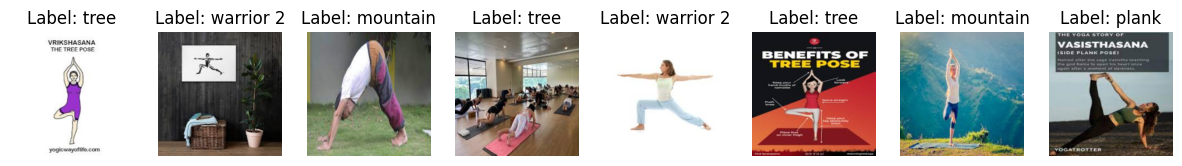

In [92]:
# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, _ = random_split(dataset, [train_size, test_size])

# Create a DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Get a batch of images and labels
sample_batch, sample_labels = next(iter(train_loader))

# Convert labels to class names
class_names = dataset.classes

# Display sample images
show_images(sample_batch, sample_labels, class_names)

In [93]:
import os
import random as r
files = []
for dirname, _, filenames in os.walk('/content/poses'):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
        # print(os.path.join(dirname, filename, "train"))
r.shuffle(files)

In [94]:
for i in range(10):
    print(files[i])

/content/poses/tree/train/133.png
/content/poses/warrior 2/train/269.png
/content/poses/mountain/train/217.png
/content/poses/mountain/train/44.png
/content/poses/mountain/train/208.png
/content/poses/plank/train/26.png
/content/poses/tree/train/228.png
/content/poses/mountain/train/156.png
/content/poses/tree/train/215.png
/content/poses/tree/train/49.png


In [95]:
!pip install opencv-python mediapipe

In [96]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils

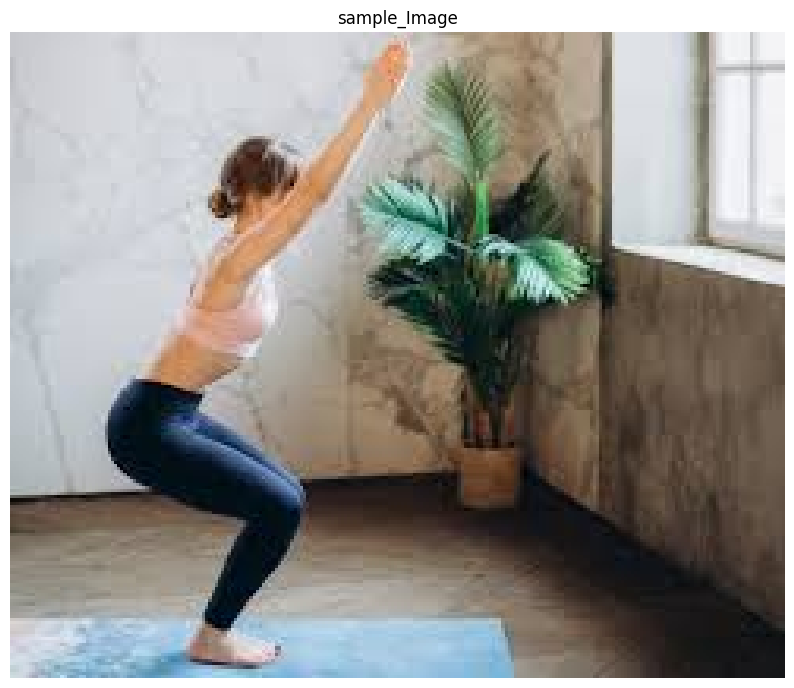

In [97]:
#Input_Image
sample_img  = cv2.imread(files[3])
plt.figure(figsize = [10,10])
plt.title("sample_Image");plt.axis('off');plt.imshow(sample_img[:,:,::-1]);plt.show()

In [98]:
# Perform pose detection after converting the image into RGB format.
results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

# Check if any landmarks are found.
if results.pose_landmarks:

    # Iterate two times as we only want to display first two landmarks.
    for i in range(2):

        # Display the found normalized landmarks.
        print(f'{mp_pose.PoseLandmark(i).name}:\n{results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]}')

NOSE:
x: 0.3786851763725281
y: 0.287887841463089
z: -0.022707102820277214
visibility: 0.9995943903923035

LEFT_EYE_INNER:
x: 0.3708164393901825
y: 0.26501911878585815
z: -0.014028197154402733
visibility: 0.9993876218795776



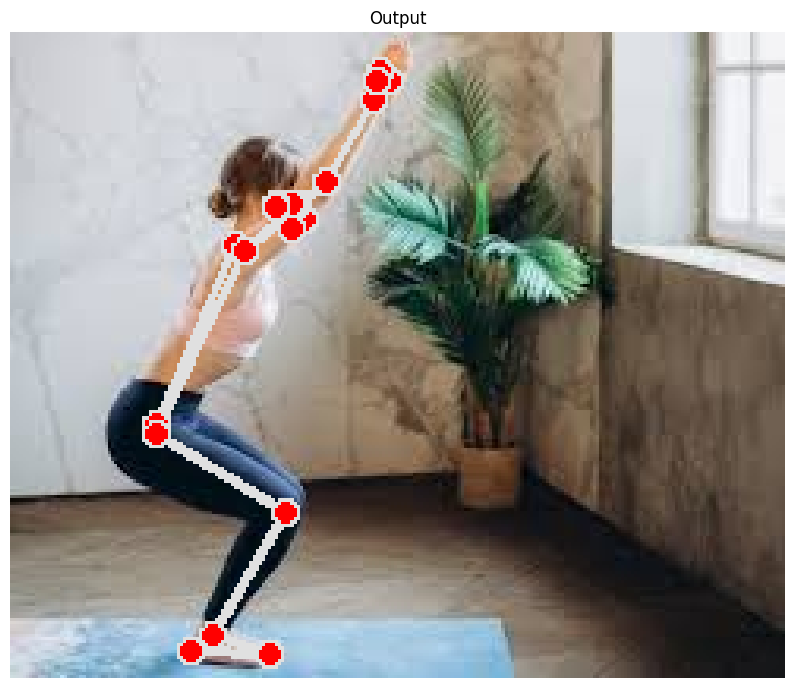

In [99]:
# Create a copy of the sample image to draw landmarks on.
img_copy = sample_img.copy()

# Check if any landmarks are found.
if results.pose_landmarks:

    # Draw Pose landmarks on the sample image.
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)

    # Specify a size of the figure.
    fig = plt.figure(figsize = [10, 10])

    # Display the output image with the landmarks drawn, also convert BGR to RGB for display.
    plt.title("Output");plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()

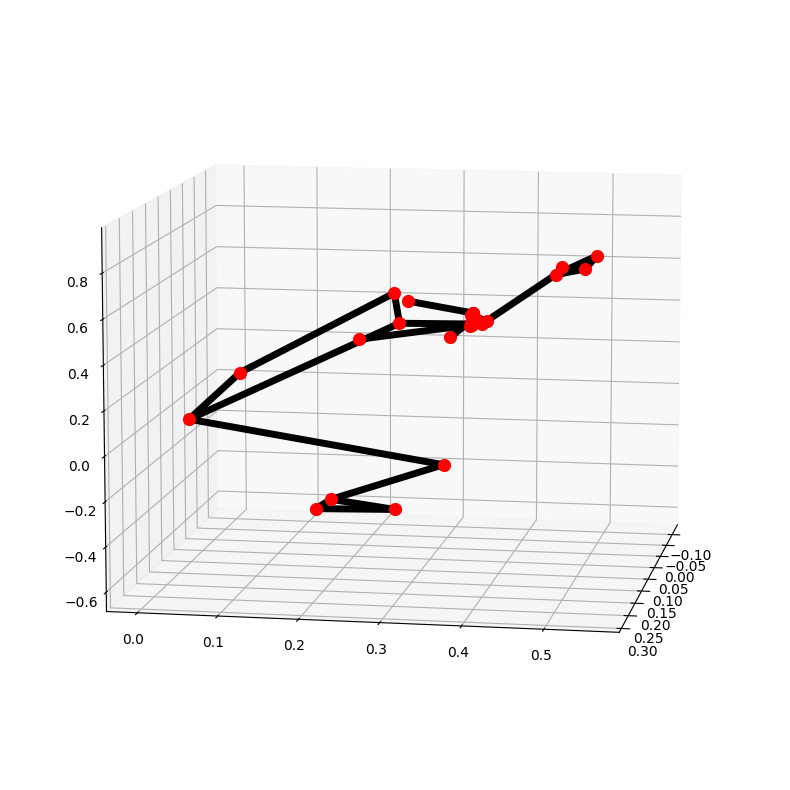

In [100]:
# Plot Pose landmarks in 3D.
mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

In [101]:
def detectPose(image, pose, display=True):
    '''
    This function performs pose detection on an image.
    Args:
        image: The input image with a prominent person whose pose landmarks needs to be detected.
        pose: The pose setup function required to perform the pose detection.
        display: A boolean value that is if set to true the function displays the original input image, the resultant image,
                 and the pose landmarks in 3D plot and returns nothing.
    Returns:
        output_image: The input image with the detected pose landmarks drawn.
        landmarks: A list of detected landmarks converted into their original scale.
    '''

    # Create a copy of the input image.

    output_image = image.copy()

    # Convert the image from BGR into RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform the Pose Detection.
    results = pose.process(imageRGB)

    # Retrieve the height and width of the input image.
    height, width, _ = image.shape

    # Initialize a list to store the detected landmarks.
    landmarks = []

    # Check if any landmarks are detected.
    if results.pose_landmarks:

        # Draw Pose landmarks on the output image.
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)

        # Iterate over the detected landmarks.
        for landmark in results.pose_landmarks.landmark:

            # Append the landmark into the list.
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))

    # Check if the original input image and the resultant image are specified to be displayed.
    if display:

        # Display the original input image and the resultant image.
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');

        # Also Plot the Pose landmarks in 3D.
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

    # Otherwise
    else:

        # Return the output image and the found landmarks.
        return output_image, landmarks

In [102]:
def calculateAngle(landmark1, landmark2, landmark3):
    '''
    This function calculates angle between three different landmarks.
    Args:
        landmark1: The first landmark containing the x,y and z coordinates.
        landmark2: The second landmark containing the x,y and z coordinates.
        landmark3: The third landmark containing the x,y and z coordinates.
    Returns:
        angle: The calculated angle between the three landmarks.

    '''

    # Get the required landmarks coordinates.
    x1, y1, _ = landmark1
    x2, y2, _ = landmark2
    x3, y3, _ = landmark3

    # Calculate the angle between the three points
    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))

    # Check if the angle is less than zero.
    if angle < 0:

        # Add 360 to the found angle.
        angle += 360

    # Return the calculated angle.
    return angle

In [103]:
#data collector
def angles_finder(landmarks):

    # Get the angle between the left shoulder, elbow and wrist points.
    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])

    # Get the angle between the right shoulder, elbow and wrist points.
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])

    # Get the angle between the left elbow, shoulder and hip points.
    left_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])

    # Get the angle between the right hip, shoulder and elbow points.
    right_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])

    # Get the angle between the left hip, knee and ankle points.
    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])

    # Get the angle between the right hip, knee and ankle points
    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])

    #----------------------------------------------------------------------------------------------------------------
    return [left_elbow_angle,right_elbow_angle,left_shoulder_angle,right_shoulder_angle,left_knee_angle,right_knee_angle]

In [104]:
def grab_data(file):
    image = cv2.imread(file)
    label = file.split('/')[3]
    output_image, landmarks = detectPose(image, pose, display=False)
    if landmarks:
        print(label)
        print(angles_finder(landmarks))

In [105]:
print(len(files))

1364


In [106]:
'/content/poses/mountain/train/88.png'.split("/")[3]

'mountain'

##Forming pandas dataframe with angles and labels

In [107]:
import pandas as pd

In [108]:
df = pd.DataFrame(columns = ['Label','left_elbow_angle','right_elbow_angle','left_shoulder_angle','right_shoulder_angle','left_knee_angle','right_knee_angle'])
print(df)

Empty DataFrame
Columns: [Label, left_elbow_angle, right_elbow_angle, left_shoulder_angle, right_shoulder_angle, left_knee_angle, right_knee_angle]
Index: []


In [109]:
for i in range(len(files)-1):
    # print(files[i])
    if '.DS_Store' in files[i]:
      continue
    image = cv2.imread(files[i])

    label = files[i].split('/')[3]
    output_image, landmarks = detectPose(image, pose, display=False)
    if landmarks:
        r = angles_finder(landmarks)
        df = pd.concat([df,pd.DataFrame.from_records([{'Label':label,'left_elbow_angle':r[0],'right_elbow_angle':r[1],'left_shoulder_angle':r[2],'right_shoulder_angle':r[3],'left_knee_angle':r[4],'right_knee_angle':r[5]}])])

In [110]:
df.head(5)

,Label,left_elbow_angle,right_elbow_angle,left_shoulder_angle,right_shoulder_angle,left_knee_angle,right_knee_angle
0,tree,170.423413,188.143767,148.534136,145.371541,187.853313,123.803412
0,warrior 2,165.621789,168.111342,164.418554,65.127128,180.000000,113.432092
0,mountain,174.038910,189.827724,17.736254,17.592425,178.458250,179.654154
0,mountain,175.815084,160.217998,158.682088,203.994314,267.847037,269.156701
0,plank,183.893708,187.594643,80.346214,115.830168,179.025783,183.685358


In [111]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
labels =[]
cols = ["Label"]
for col in cols:
    df[col] = le.fit_transform(df[col])
    labels = le.classes_
print(labels)

['down dog' 'mountain' 'plank' 'tree' 'warrior 2']


In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [113]:
y = df["Label"]
X = df.drop("Label",axis=1)

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=42)

In [114]:
clf = RandomForestClassifier(random_state = 42,
                             n_jobs = 1,
                             n_estimators = 1000).fit(X_train, y_train)

In [115]:
labels

array(['down dog', 'mountain', 'plank', 'tree', 'warrior 2'], dtype=object)

In [116]:
def Pred_fun(filename):
    image = cv2.imread(filename)
    label = filename.split('/')[3]
    output_image, landmarks = detectPose(image, pose, display=False)
    if landmarks:
        result = angles_finder(landmarks)
        print(result)
        prediction = clf.predict(np.array(result).reshape(1,-1))
        print("Actual Label:",label," Predicted Label:",labels[prediction])
        cv2.putText(output_image, label, (10, 30),cv2.FONT_HERSHEY_PLAIN, 1,(0, 0, 255), 2)
        cv2.putText(output_image, str(labels[prediction]), (10, 50),cv2.FONT_HERSHEY_PLAIN, 1,(0, 255, 0),2)
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');

[183.1221304621157, 194.7314058709173, 271.7899106082461, 77.49255536946816, 168.67693532829247, 168.3952376436212]
Actual Label: plank  Predicted Label: ['plank']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


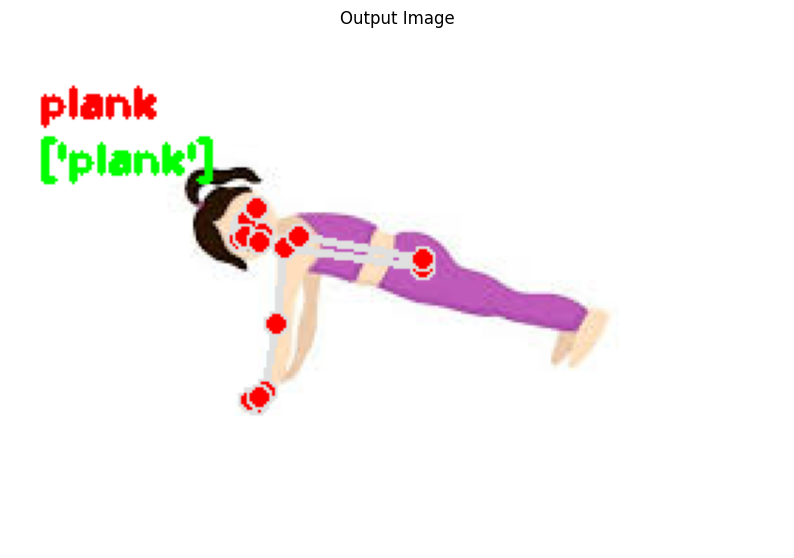

In [117]:
Pred_fun(files[249])

In [118]:
from sklearn.metrics import accuracy_score
prediction = clf.predict(X_val)
# print accuracy metrics
print("Accuracy:",accuracy_score(y_val,prediction))

Accuracy: 0.75


[176.07881702867553, 198.8501283640669, 130.03567338736238, 192.42353308345326, 93.3664606634298, 177.80273407561356]
Actual Label: down dog  Predicted Label: ['down dog']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[166.48269103263505, 207.61502809467677, 182.4640015420048, 165.5679370638641, 315.0568974783308, 177.5289079995137]
Actual Label: tree  Predicted Label: ['tree']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[158.18595916916297, 200.38212101112973, 172.12470565885118, 173.08587764375736, 180.08641890809153, 181.21151263179058]
Actual Label: mountain  Predicted Label: ['mountain']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[203.62937773065684, 172.08583549095232, 95.52754015165618, 109.2147471496794, 181.89672407227673, 100.09105723888892]
Actual Label: warrior 2  Predicted Label: ['warrior 2']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[179.2591475906107, 178.008924059833, 13.295391058537136, 14.384365439346421, 182.006701668555, 181.4661166941736]
Actual Label: mountain  Predicted Label: ['mountain']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[187.9871312734481, 166.74198251946484, 18.030038394136252, 20.087749860157416, 176.51933603482874, 180.79657448437027]
Actual Label: mountain  Predicted Label: ['mountain']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[283.73626830562256, 280.0857837516789, 358.612260997312, 3.7026226561470037, 176.09950625761812, 176.46154344377865]
Actual Label: mountain  Predicted Label: ['mountain']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[175.6012946450045, 198.434948822922, 196.0735741647464, 180.0, 181.39378290266285, 25.896022588874462]
Actual Label: tree  Predicted Label: ['tree']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[151.47042843960858, 76.27871452080424, 99.95062668795163, 273.04054730559255, 202.4284695938201, 192.72435568542235]
Actual Label: plank  Predicted Label: ['plank']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


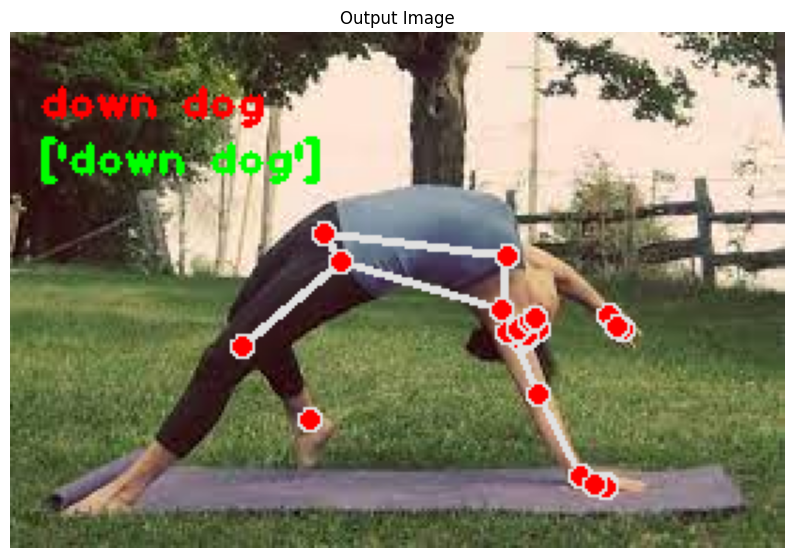

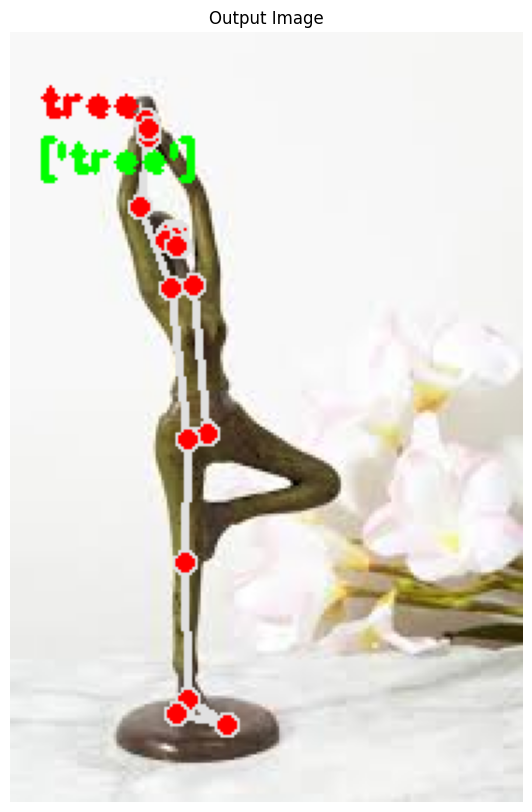

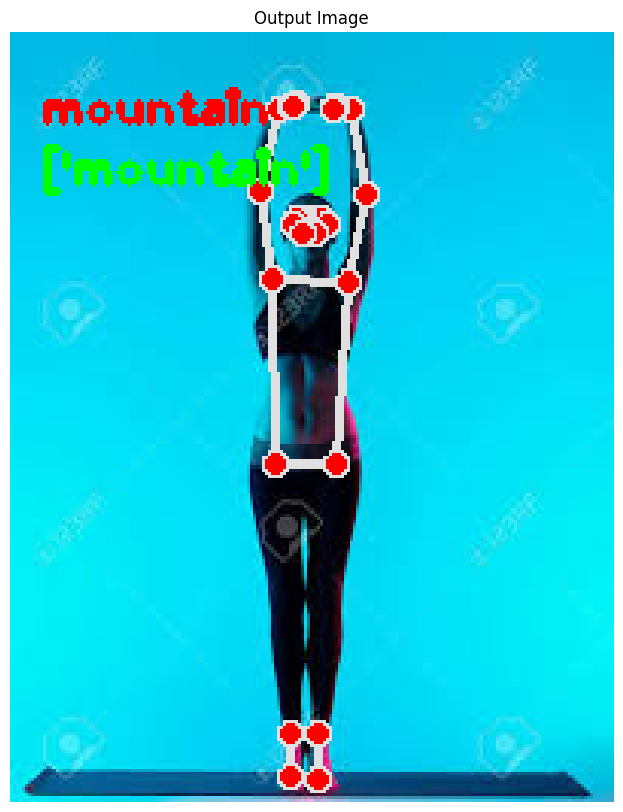

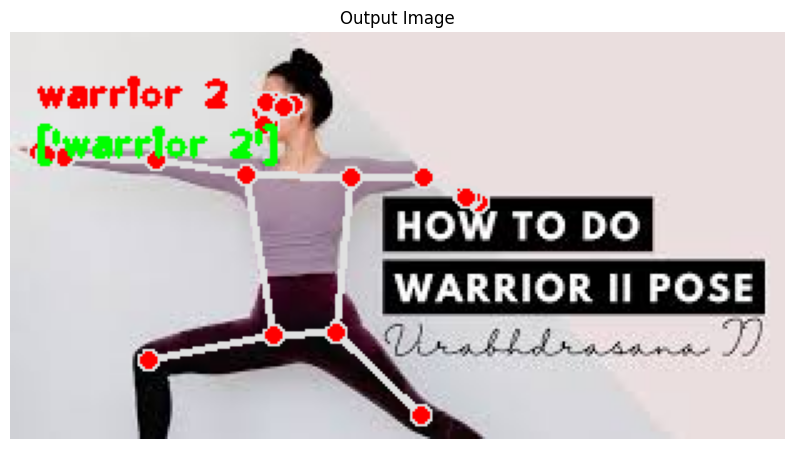

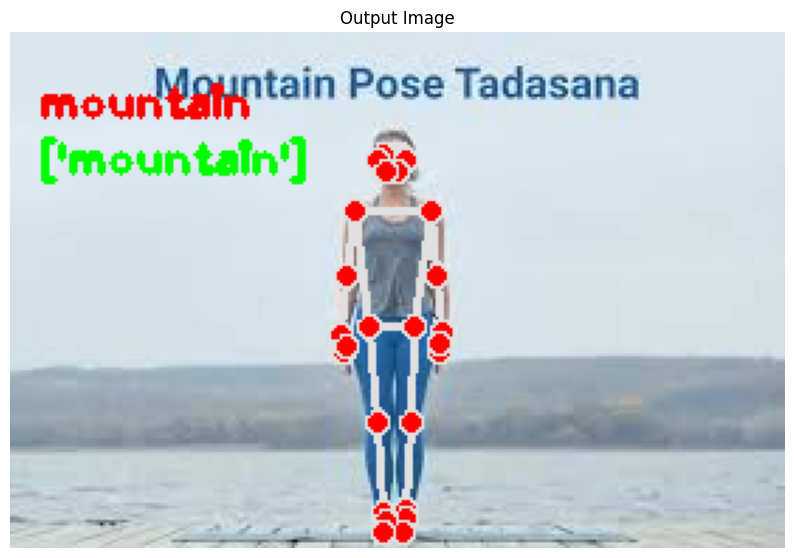

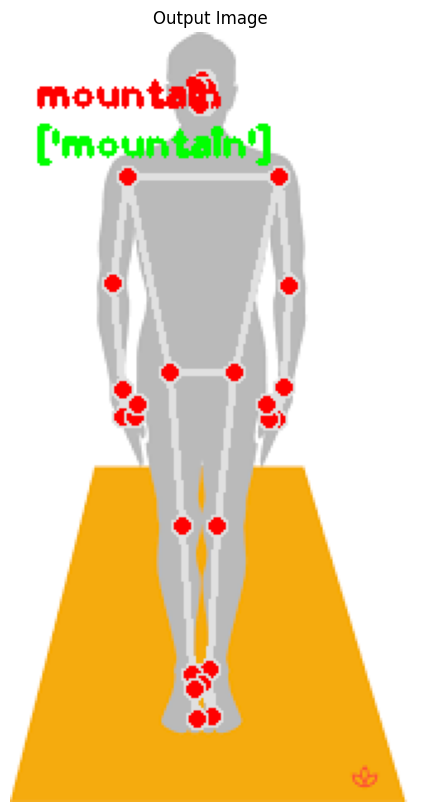

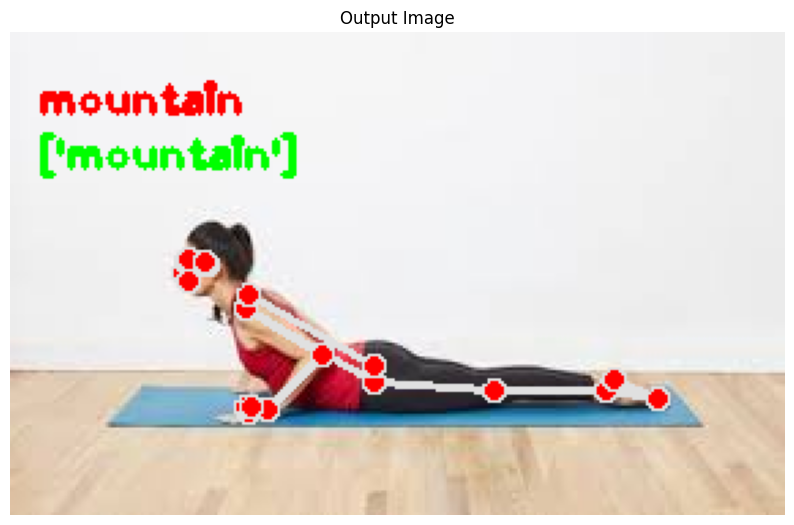

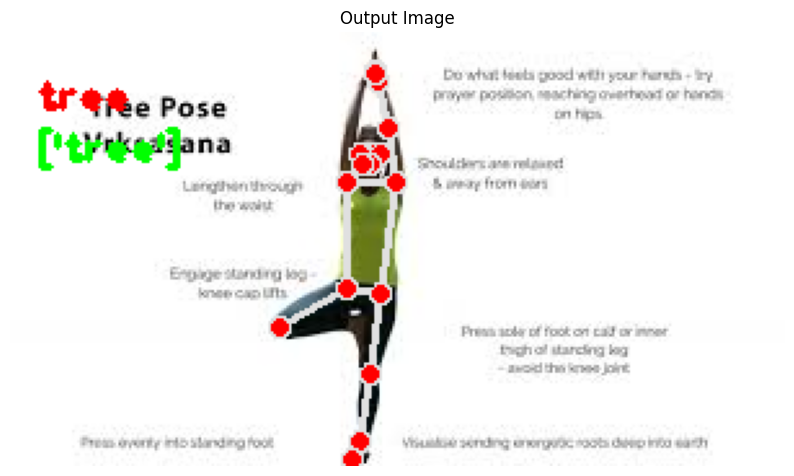

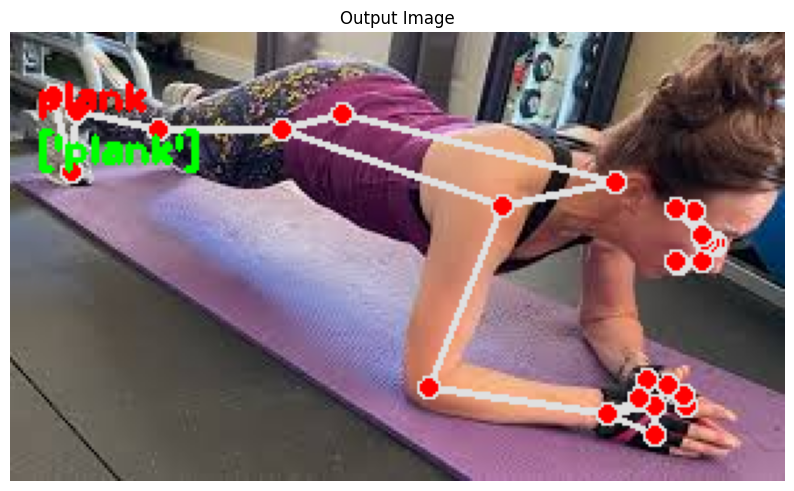

In [119]:
for i in range(10,20):
    Pred_fun(files[i])